In [ ]:
# Step 1: Define Dataset Class for Loading Images
class MalwareDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = []
        self.labels = []

        # Load malware images
        malware_dir = os.path.join(image_dir, "malware")
        for img_name in os.listdir(malware_dir):
            self.image_paths.append(os.path.join(malware_dir, img_name))
            self.labels.append(1)  # 1 for malware

        # Load benign images
        benign_dir = os.path.join(image_dir, "benign")
        for img_name in os.listdir(benign_dir):
            self.image_paths.append(os.path.join(benign_dir, img_name))
            self.labels.append(0)  # 0 for benign

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        img = Image.open(img_path).convert("L")  # Ensure grayscale
        if self.transform:
            img = self.transform(img)

        return img, label

# Step 2: Define Efficient CNN Architecture
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Input: 1 channel (grayscale)
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        )
        self.fc = nn.Linear(256, 256)  # Output 256-dim feature vector

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Step 3: Train CNN Model with Learning Rate Scheduler
def train_cnn_model(dataset, batch_size=32, epochs=10, device="cuda"):
    # Split dataset into train and validation sets
    train_indices, val_indices = train_test_split(
        range(len(dataset)), test_size=0.2, random_state=42
    )
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, optimizer, and scheduler
    model = FeatureExtractorCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            # Forward passasdasda
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / val_total
        print(f"Validation Accuracy: {val_acc:.4f}")

        # Step the learning rate scheduler
        scheduler.step()

    # torch.save(model.state_dict(), "bin_cnn_model.pth")  # Save the trained model
    return model

# Step 4: Extract Features Using Trained CNN
def extract_features(model, dataset, batch_size=32, device="cuda"):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            feature = model(imgs)
            features.append(feature.cpu().numpy())
            labels.extend(lbls.numpy())

    return np.vstack(features), np.array(labels)

# Step 5: Train XGBoost Model
def train_xgboost_model(features, labels):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42
    )

    # Train XGBoost model
    model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"XGBoost Accuracy: {accuracy:.4f}")
    # model.save_model("xgb_model.json")  # Save the trained model
    return model

# Main Workflow
if __name__ == "__main__":
    # Define paths
    image_dir = "./data/bin_imgs"  # Directory containing 'malware' and 'benign' subdirectories

    # Define transformations (resize images to a fixed size)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize all images to 128x128
        transforms.ToTensor(),          # Convert to tensor
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
    ])

    # Load dataset
    dataset = datasets.ImageFolder(root=image_dir, transform=transform)

    # Train CNN model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    cnn_model = train_cnn_model(dataset, batch_size=32, epochs=10, device=device)

    # Extract features
    features, labels = extract_features(cnn_model, dataset, batch_size=32, device=device)

    # Train XGBoost model
    xgb_model = train_xgboost_model(features, labels)

Epoch 1/10, Loss: 23.1528, Accuracy: 0.7400
Validation Accuracy: 0.7000
Epoch 2/10, Loss: 8.2459, Accuracy: 0.8750
Validation Accuracy: 0.6550
Epoch 3/10, Loss: 7.1315, Accuracy: 0.8988
Validation Accuracy: 0.8150
Epoch 4/10, Loss: 6.3102, Accuracy: 0.9137
Validation Accuracy: 0.8550
Epoch 5/10, Loss: 5.4407, Accuracy: 0.9287
Validation Accuracy: 0.8850
Epoch 6/10, Loss: 6.0154, Accuracy: 0.9225
Validation Accuracy: 0.8950
Epoch 7/10, Loss: 5.1354, Accuracy: 0.9425
Validation Accuracy: 0.9050
Epoch 8/10, Loss: 5.2572, Accuracy: 0.9313
Validation Accuracy: 0.8850
Epoch 9/10, Loss: 5.1844, Accuracy: 0.9337
Validation Accuracy: 0.8900
Epoch 10/10, Loss: 5.3646, Accuracy: 0.9300
Validation Accuracy: 0.8800


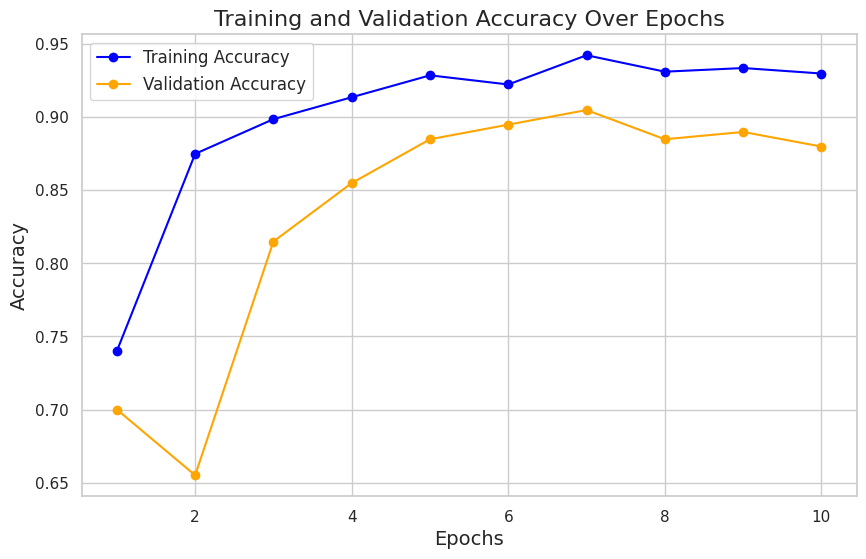

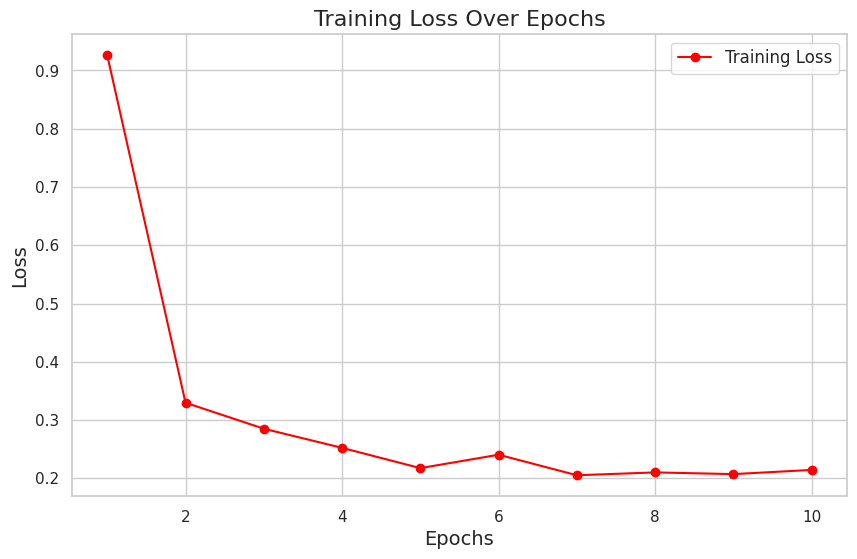

/home/arnavw/Code/ml/GAJSHIELD_KJSCE/model/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:45:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9150


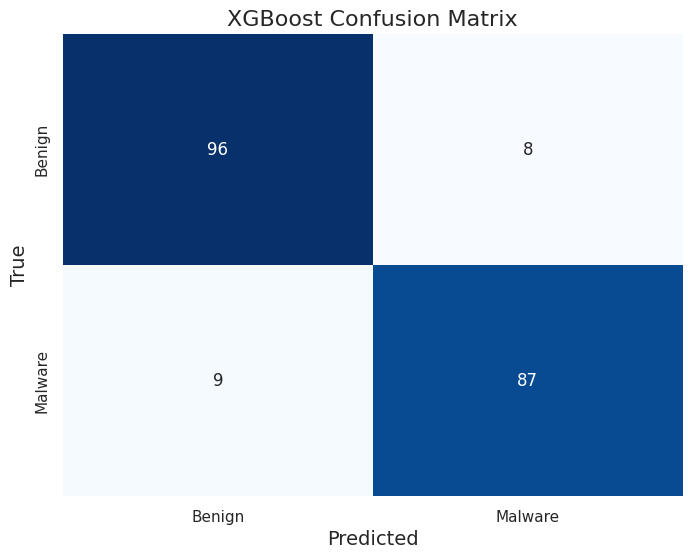

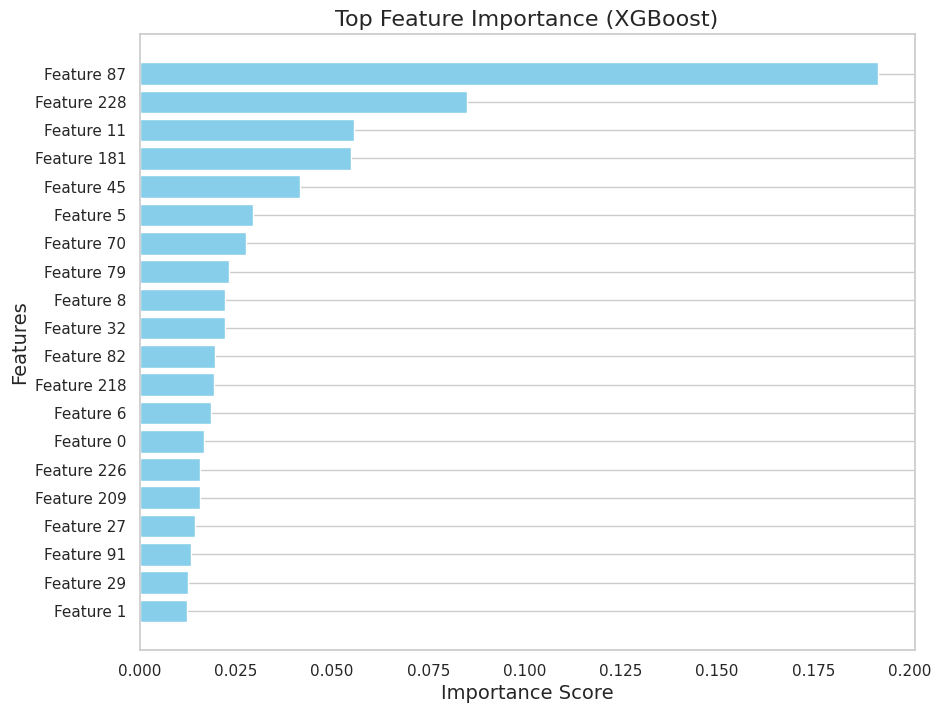

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define Dataset Class for Loading Images
class MalwareDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = []
        self.labels = []

        # Load malware images
        malware_dir = os.path.join(image_dir, "malware")
        for img_name in os.listdir(malware_dir):
            self.image_paths.append(os.path.join(malware_dir, img_name))
            self.labels.append(1)  # 1 for malware

        # Load benign images
        benign_dir = os.path.join(image_dir, "benign")
        for img_name in os.listdir(benign_dir):
            self.image_paths.append(os.path.join(benign_dir, img_name))
            self.labels.append(0)  # 0 for benign

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        img = Image.open(img_path).convert("L")  # Ensure grayscale
        if self.transform:
            img = self.transform(img)

        return img, label

# Step 2: Define Efficient CNN Architecture
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Input: 1 channel (grayscale)
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        )
        self.fc = nn.Linear(256, 256)  # Output 256-dim feature vector

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Step 3: Train CNN Model with Learning Rate Scheduler
def train_cnn_model(dataset, batch_size=32, epochs=10, device="cuda"):
    # Split dataset into train and validation sets
    train_indices, val_indices = train_test_split(
        range(len(dataset)), test_size=0.2, random_state=42
    )
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, optimizer, and scheduler
    model = FeatureExtractorCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Lists to store metrics for plotting
    train_losses, train_accs, val_accs = [], [], []

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            # Forward pass
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accs.append(train_acc)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / val_total
        val_accs.append(val_acc)
        print(f"Validation Accuracy: {val_acc:.4f}")

        # Step the learning rate scheduler
        scheduler.step()

    # Plot training history
    plot_training_history(train_accs, val_accs)
    plot_loss_curve(train_losses)
    return model

# Step 4: Extract Features Using Trained CNN
def extract_features(model, dataset, batch_size=32, device="cuda"):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            feature = model(imgs)
            features.append(feature.cpu().numpy())
            labels.extend(lbls.numpy())

    return np.vstack(features), np.array(labels)

# Step 5: Train XGBoost Model
def train_xgboost_model(features, labels):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42
    )

    # Train XGBoost model
    model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"XGBoost Accuracy: {accuracy:.4f}")

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, title="XGBoost Confusion Matrix")

    # Plot feature importance
    plot_feature_importance(model, num_features=20)

    return model

# Visualization Functions
def plot_training_history(train_accs, val_accs):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    epochs = range(1, len(train_accs) + 1)
    plt.plot(epochs, train_accs, label="Training Accuracy", marker='o', color='blue')
    plt.plot(epochs, val_accs, label="Validation Accuracy", marker='o', color='orange')
    
    plt.title("Training and Validation Accuracy Over Epochs", fontsize=16)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

def plot_loss_curve(train_losses):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label="Training Loss", marker='o', color='red')
    
    plt.title("Training Loss Over Epochs", fontsize=16)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
    
    plt.title(title, fontsize=16)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("True", fontsize=14)
    plt.show()

def plot_feature_importance(model, num_features=20):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 8))
    
    # Get feature importance
    importance = model.feature_importances_
    indices = np.argsort(importance)[-num_features:]  # Top N features
    
    plt.barh(range(len(indices)), importance[indices], color="skyblue")
    plt.yticks(range(len(indices)), [f"Feature {i}" for i in indices])
    
    plt.title("Top Feature Importance (XGBoost)", fontsize=16)
    plt.xlabel("Importance Score", fontsize=14)
    plt.ylabel("Features", fontsize=14)
    plt.grid(axis='x')
    plt.show()

# Main Workflow
if __name__ == "__main__":
    # Define paths
    image_dir = "./data/bin_imgs"  # Directory containing 'malware' and 'benign' subdirectories

    # Define transformations (resize images to a fixed size)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize all images to 128x128
        transforms.ToTensor(),          # Convert to tensor
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
    ])

    # Load dataset
    dataset = MalwareDataset(image_dir, transform=transform)

    # Train CNN model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    cnn_model = train_cnn_model(dataset, batch_size=32, epochs=10, device=device)

    # Extract features
    features, labels = extract_features(cnn_model, dataset, batch_size=32, device=device)

    # Train XGBoost model
    xgb_model = train_xgboost_model(features, labels)